In [85]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

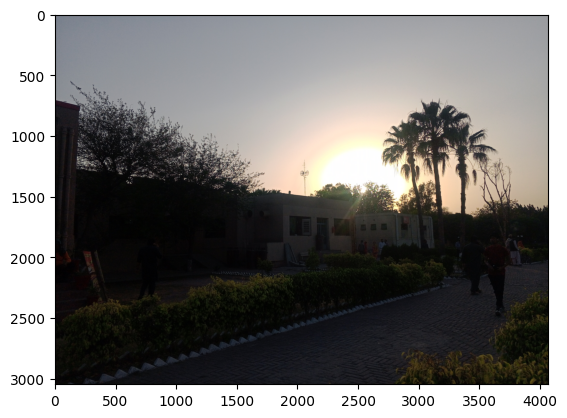

In [86]:
checkerboard = cv2.imread(r"../source/img_5.jpg")
checkerboard = cv2.cvtColor(checkerboard, cv2.COLOR_BGR2RGB)/255
plt.imshow(checkerboard)

In [87]:
def compute_derivatives(img):
    # Using sobel filter

    Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize= 1)
    Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize= 1)
    return Ix, Iy
Ix, Iy = compute_derivatives(checkerboard[:,:,0])


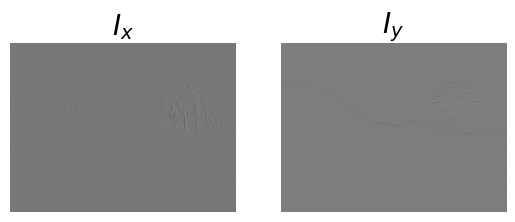

In [88]:
fig, ax = plt.subplots(1, 2)

ax[0].set_title('$I_x$', fontsize = 20)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].imshow(Ix, cmap="gray")
ax[1].set_title('$I_y$', fontsize = 20)
ax[1].imshow(Iy, cmap="gray")

In [89]:
def harris(Ix, Iy, window_size=3, k=0.04):

    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    kernel = np.ones((window_size, window_size))

    Sxx = cv2.filter2D(Ixx, -1, kernel)
    Syy = cv2.filter2D(Iyy, -1, kernel)
    Sxy = cv2.filter2D(Ixy, -1, kernel)

    det = (Sxx * Syy) - (Sxy ** 2)
    trace = Sxx + Syy

    R = det - k * (trace ** 2)

    return R


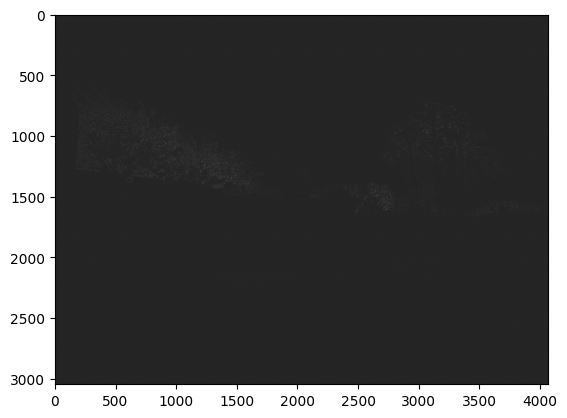

In [90]:
corners = harris(Ix, Iy, 3)
plt.imshow(corners, cmap = "gray")
plt.show()

In [91]:
def corner_detections(harris_matrix,radius, thresh):
  rows, cols = harris_matrix.shape
  window_size = radius*2 + 1
  kernel = np.ones((window_size, window_size))

  iterations = window_size**2
  dilated = cv2.dilate(harris_matrix,kernel, iterations)
  bordermask = np.zeros_like(harris_matrix)
  bordermask[radius:-radius, radius:-radius] = 1
  maxima = np.logical_and(np.logical_and(harris_matrix == dilated, harris_matrix > thresh), bordermask)
  detections = np.where(maxima)

  return detections


def draw_detections(img, detections, cross_halfsize = 3):

  image = img.copy()
  rows, cols = detections


  for row, col in zip(rows, cols):
    start_point = (col, row - cross_halfsize)
    end_point = (col, row + cross_halfsize)
    color = (1, 0, 0)
    thickness = 1
    img = cv2.line(image, start_point, end_point, color, thickness)
    start_point = (col - cross_halfsize, row)
    end_point = (col + cross_halfsize, row)
    img = cv2.line(image, start_point, end_point, color, thickness)


  plt.imshow(img)



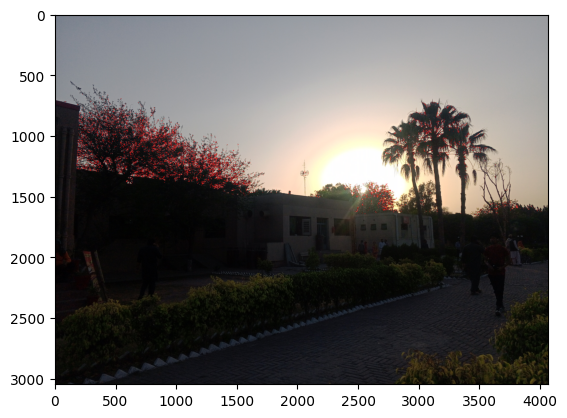

In [92]:
detections = corner_detections(corners,1, 0.5)
draw_detections(checkerboard, detections)

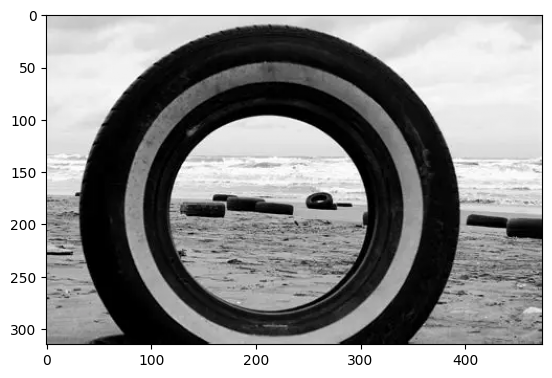

In [ ]:
img = cv2.imread(r"../source/circle.webp")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255
plt.imshow(img)

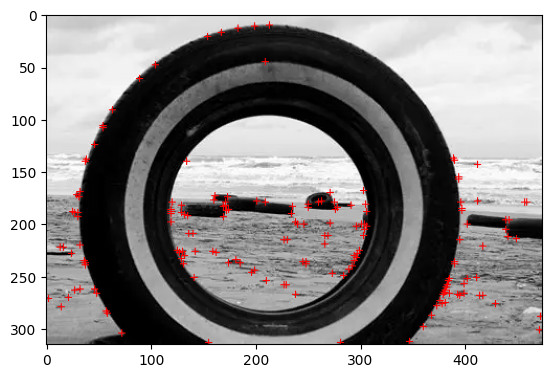

In [106]:
img = cv2.imread(r"../source/circle.webp")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255
img_modified = cv2.GaussianBlur(img,(3,3),1)
Ix, Iy = compute_derivatives(img_modified[:,:,0])
corners = harris(Ix, Iy, 3)
detections = corner_detections(corners,1, 0.01)
draw_detections(img, detections)

# Image stitching

In [74]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

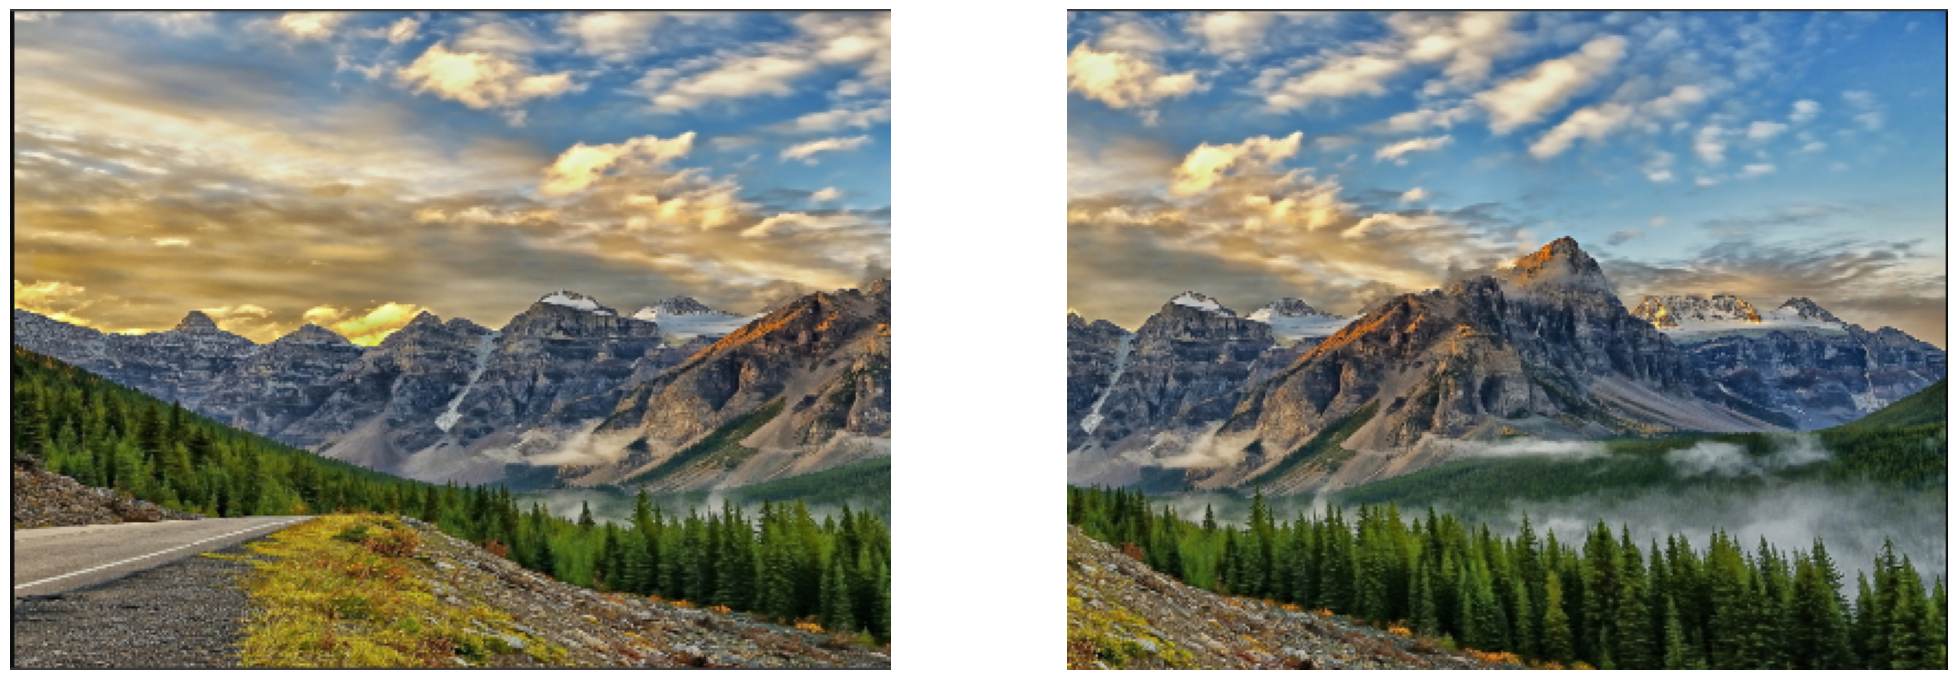

In [75]:
org_1 = plt.imread("../source/img_1_stitch.png")
org_2 = plt.imread("../source/img_2_stitch.png")
org_1 = cv2.resize(org_1, (400, 300))
org_2 = cv2.resize(org_2, (400, 300))

fig, ax = plt.subplots(1, 2, figsize= (25, 25))
for a in ax:
    a.set_axis_off()
ax[0].imshow(org_1)
ax[1].imshow(org_2)

In [76]:
def get_orb_features(img):
    orb = cv2.ORB_create()
    kp = orb.detect(img, None)
    kp, des = orb.compute(img, kp)
    return kp, des

def match_keypoints(desc_1, desc_2):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desc_1, desc_2)
    matches = sorted(matches, key = lambda x:x.distance)

    return matches

def prepare_for_drawing(img):
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    if img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    return img


keypoints for img1 and img2


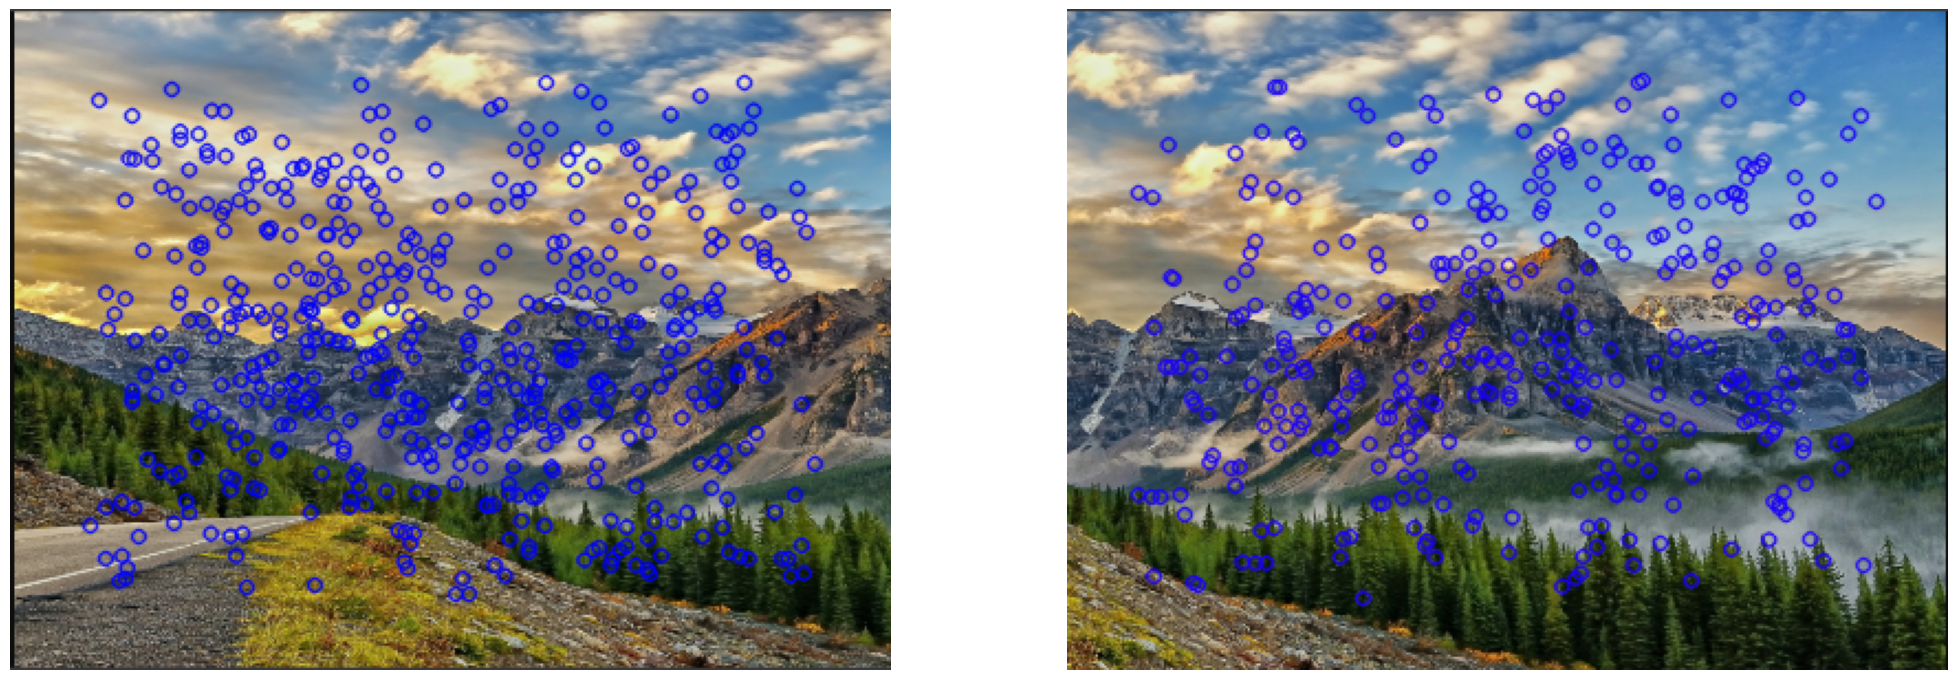

In [77]:
kp_1, desc_1 = get_orb_features(org_1)
kp_2, desc_2 = get_orb_features(org_2)

org_1 = prepare_for_drawing(org_1)
org_2 = prepare_for_drawing(org_2)

kp_org_1 = cv2.drawKeypoints(org_1, kp_1, None, color=(0, 0, 250), flags=0)
kp_org_2 = cv2.drawKeypoints(org_2, kp_2, None, color=(25, 0, 250), flags=0)

print("keypoints for img1 and img2")
fig, ax = plt.subplots(1, 2, figsize= (25, 25))
for a in ax:
    a.set_axis_off()
ax[0].imshow(kp_org_1)
ax[1].imshow(kp_org_2)


In [78]:
matches = match_keypoints(desc_1, desc_2)
match_plot = cv2.drawMatches(org_1, kp_1, org_2, kp_2, matches[:20], None, flags=2)
match_plot = cv2.cvtColor(match_plot, cv2.COLOR_RGB2BGR)
print("Draw 20 best matches")
cv2.imshow("matches", match_plot)
cv2.waitKey(0)
cv2.destroyAllWindows()

Draw 20 best matches


In [79]:
def proj(H, pts_2):

    H = np.reshape(H, (3,3))
    N = pts_2.shape[0]
    h_pts_2 = np.append(pts_2, np.ones((N,1)), axis = 1)
    proj = H@h_pts_2.T
    proj /= proj[2, :]
    proj = proj[:2, :].T
    return proj

In [80]:
def find_homography(pts_1, pts_2):

  N = pts_1.shape[0]
  A = np.zeros((2*N,9))

  for i in range(N):
    A[i*2, :] = [-pts_2[i, 0], -pts_2[i, 1], -1, 0, 0, 0, pts_1[i,0]*pts_2[i,0],pts_1[i,0]*pts_2[i,1], pts_1[i,0]]
    A[i*2+1,:] = [0, 0, 0, -pts_2[i, 0], -pts_2[i, 1], -1, pts_2[i,0]*pts_1[i,1],pts_2[i,1]*pts_1[i,1], pts_1[i,1]]



  U,S,V = np.linalg.svd(A)
  H = V[8]/V[8,-1]
  H = H.reshape((3,3))

  return H

In [87]:
def panoramic_stitching(img1, img2, num_matches):

  kp_1, desc_1 = get_orb_features(img1)
  kp_2, desc_2 = get_orb_features(img2)
  matches = match_keypoints(desc_1, desc_2)
  matches = matches[:num_matches]
  pts_1 = np.array([list(kp_1[match.queryIdx].pt) for match in matches])
  pts_2 = np.array([list(kp_2[match.trainIdx].pt) for match in matches])
  H = find_homography(pts_1, pts_2)
  final_img = cv2.warpPerspective(img2, H, (img2.shape[1]+img1.shape[1], img2.shape[0]))
  final_img[0:img1.shape[0], 0:img1.shape[1]] = img1


  return final_img

In [88]:
print("Camera stitching using 4 points")
result = panoramic_stitching(org_1, org_2, 4)
result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
cv2.imshow("Panoramic_View", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

print("Camera stitching using 20 points")
result = panoramic_stitching(org_1, org_2, 20)
result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
cv2.imshow("Panoramic_View", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

print("Camera stitching using 30 points")
result = panoramic_stitching(org_1, org_2, 30)
result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
cv2.imshow("Panoramic_View", result)
cv2.waitKey(0)
cv2.destroyAllWindows()


Camera stitching using 4 points
Camera stitching using 20 points
Camera stitching using 30 points
